# 1. Importing all the requried packages and modules

In [31]:
import os
import cv2
import tensorflow
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, Xception, InceptionResNetV2, ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

# 2. Data Loading

In [32]:
data_dir = 'data/finalData'

In [33]:
categories  = ['urban', 'agriculture', 'forest', 'water']
data = []
data_labels = []

for categorie in categories :
    folder_path = os.path.join(data_dir, categorie)
    image_paths = os.listdir(folder_path)
    data.extend([os.path.join(folder_path, image_path) for image_path in image_paths])
    data_labels.extend([categorie] * len(image_paths))
data = pd.DataFrame({'Image_Path' : data, 'labels' : data_labels})
data

,Image_Path,labels
0,data/finalData\urban\Industrial_1.jpg,urban
1,data/finalData\urban\Industrial_10.jpg,urban
2,data/finalData\urban\Industrial_100.jpg,urban
3,data/finalData\urban\Industrial_1000.jpg,urban
4,data/finalData\urban\Industrial_1001.jpg,urban
...,...,...
24995,data/finalData\water\SeaLake_997.jpg,water
24996,data/finalData\water\SeaLake_998 - Copy.jpg,water
24997,data/finalData\water\SeaLake_998.jpg,water
24998,data/finalData\water\SeaLake_999 - Copy.jpg,water


# 3. Data Visualization 

Displaying Some Sample images of 'urban' categorie : 


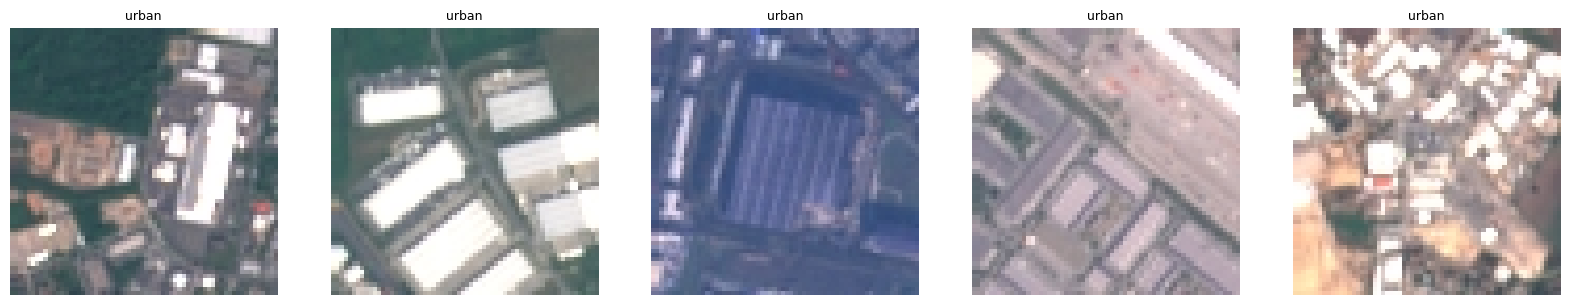

Displaying Some Sample images of 'agriculture' categorie : 


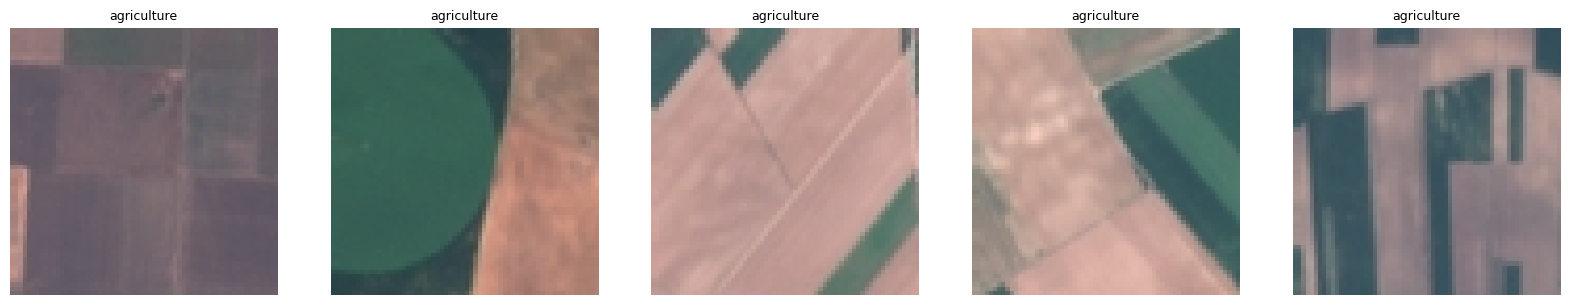

Displaying Some Sample images of 'forest' categorie : 


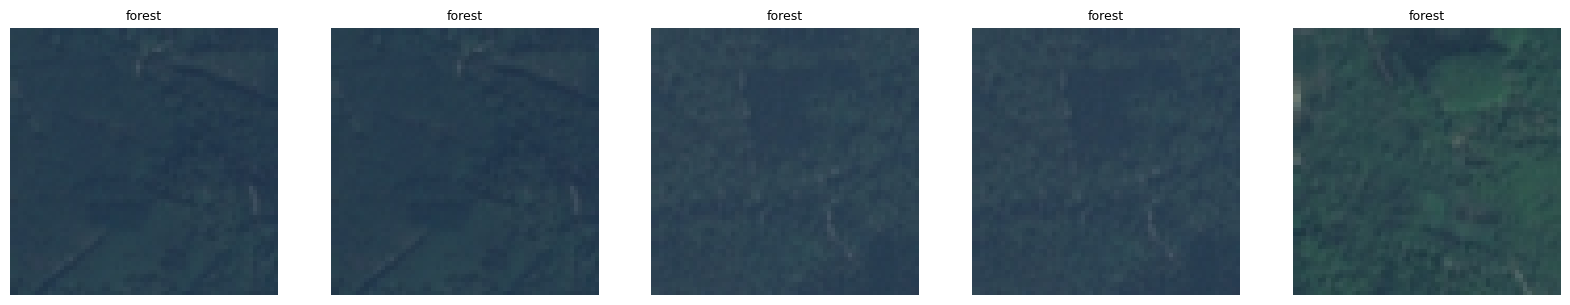

Displaying Some Sample images of 'water' categorie : 


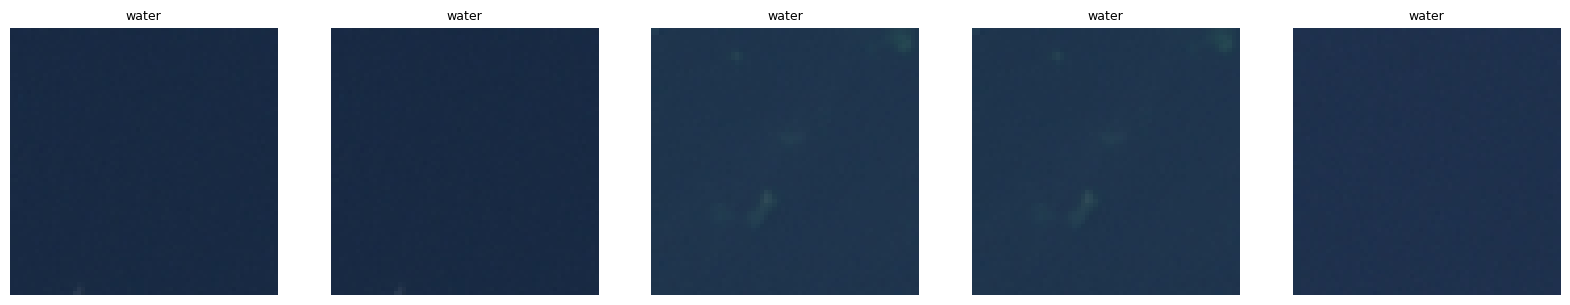

In [34]:
labels = ['urban', 'agriculture', 'forest', 'water']

for label in labels:
    sample_images = data[data['labels'] == label]['Image_Path'].reset_index(drop=True)[:5]

    print(f"Displaying Some Sample images of '{label}' categorie : ")
    # Displaying Some Sample images in RGB
    plt.figure(figsize=(20, 8))
    for i in range(len(sample_images)):
        plt.subplot(2, 5, i + 1 + 5)
        img = cv2.imread(sample_images[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(label, fontsize=9)
        plt.axis('off')
        
    plt.show()

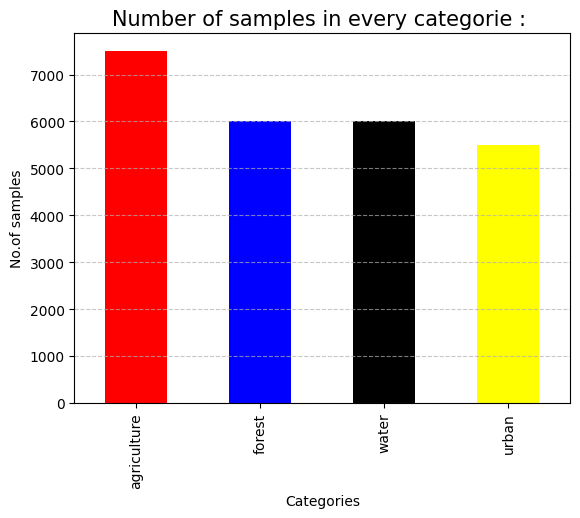

In [35]:
data['labels'].value_counts().plot(kind = 'bar', color = ['red', 'blue', 'black', 'yellow'])
plt.title('Number of samples in every categorie : ', fontsize = 15)
plt.xlabel('Categories')
plt.ylabel('No.of samples')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 4. Data Preprocessing and Augmentation

In [36]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.25,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.3,
    horizontal_flip = True,
    zoom_range = 0.2,
    brightness_range=[0.8, 1.2],  # Adjust brightness
    fill_mode='nearest' 
)


In [37]:
# Training Data
train_data = datagen.flow_from_directory(
    data_dir,
    target_size=(75, 75),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation Data
val_data = datagen.flow_from_directory(
    data_dir,
    target_size=(75, 75),
    batch_size=1,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Test Data (Separate folder or another 10% of data)
test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for test data
test_data = test_datagen.flow_from_directory(
    data_dir,
    target_size=(75, 75),
    batch_size=10,
    class_mode='categorical',
    shuffle=True
)

Found 18750 images belonging to 4 classes.
Found 6250 images belonging to 4 classes.
Found 25000 images belonging to 4 classes.


In [38]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights = dict(enumerate(class_weights))

# 5. Building the models

In [39]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

model = Sequential()

# 1st Convolutional Block
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='swish', kernel_regularizer=l2(0.0005), input_shape=(75,75,3)))
model.add(BatchNormalization())  
model.add(MaxPooling2D(pool_size=(2,2)))

# 2nd Convolutional Block
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='swish', kernel_regularizer=l2(0.0005)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# 3rd Convolutional Block
model.add(Conv2D(filters=256, kernel_size=(3,3), activation='swish', kernel_regularizer=l2(0.0005)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# 4th Convolutional Block
model.add(Conv2D(filters=512, kernel_size=(3,3), activation='swish', kernel_regularizer=l2(0.0005)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Feature Extraction: Global Average Pooling
model.add(GlobalAveragePooling2D())

# Fully Connected Layers
model.add(Dense(1024, activation='swish', kernel_regularizer=l2(0.0005)))
model.add(Dropout(0.6))  # Increased dropout
model.add(Dense(train_data.num_classes, activation='softmax'))  # Output Layer


c:\Users\Dell\anaconda3\envs\dl_kerasocr\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [84]:
from tensorflow.keras.utils import plot_model
# Generate and save the model plot
plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


# 6. Compiling and Training the models

In [40]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy']
            )

In [41]:
# EarlyStoping the model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# Learning Rate Decay
lrd = ReduceLROnPlateau(monitor = 'val_loss', patience = 5,verbose = 1,factor = 0.50, min_lr = 1e-10)

In [42]:
# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    class_weight=class_weights,
    callbacks=[es, lrd]
)

# 21min 19sec

c:\Users\Dell\anaconda3\envs\dl_kerasocr\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 574s 972ms/step - accuracy: 0.8066 - loss: 1.1248 - val_accuracy: 0.8690 - val_loss: 0.9529 - learning_rate: 1.0000e-04
Epoch 2/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 509s 868ms/step - accuracy: 0.9064 - loss: 0.8708 - val_accuracy: 0.8515 - val_loss: 0.9749 - learning_rate: 1.0000e-04
Epoch 3/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 505s 861ms/step - accuracy: 0.9168 - loss: 0.8048 - val_accuracy: 0.9293 - val_loss: 0.7670 - learning_rate: 1.0000e-04
Epoch 4/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 508s 867ms/step - accuracy: 0.9316 - loss: 0.7346 - val_accuracy: 0.9357 - val_loss: 0.7082 - learning_rate: 1.0000e-04
Epoch 5/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 504s 860ms/step - accuracy: 0.9190 - loss: 0.7496 - val_accuracy: 0.9237 - val_loss: 0.6790 - learning_rate: 1.0000e-04
Epoch 6/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 502s 856ms/step - accuracy: 0.9450 - loss: 0.6404 - val_accuracy: 0.9554 - val_loss: 0.6107 - learning_rate: 1.0000e-04
Epoch 7/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 

In [43]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 73, 73, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 73, 73, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 5, 5, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 5, 5, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,248,846 (23.84 MB)

 Trainable params: 2,082,308 (7.94 MB)

 Non-trainable params: 1,920 (7.50 KB)

 Optimizer params: 4,164,618 (15.89 MB)

In [44]:
# Save the model
model.save("finalDataModel.keras")

# 7. Models Evaluate on validation data

In [45]:
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Model4 Validation Loss: {val_loss}")
print(f"Model4 Validation Accuracy: {val_accuracy}")

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 91s 15ms/step - accuracy: 0.9370 - loss: 0.3023
Model4 Validation Loss: 0.4311249852180481
Model4 Validation Accuracy: 0.8831999897956848


# 8. Model performance Visualization

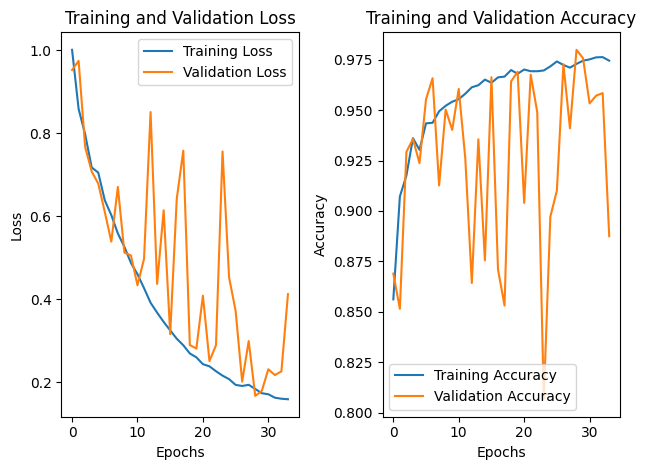

In [46]:
# Plotting the training and validation los

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [47]:
class_names = list(val_data.class_indices.keys())

# Get predictions for the validation data
val_predictions = model.predict(val_data)
y_pred = np.argmax(val_predictions, axis=1)  # Predicted classes
y_true = val_data.classes  # True classes from the generator

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 74s 12ms/step


In [48]:
print("\nTest Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_data.class_indices.keys())))


Test Classification Report:
              precision    recall  f1-score   support

 agriculture       0.97      0.92      0.94      1875
      forest       0.70      1.00      0.82      1500
       urban       0.98      1.00      0.99      1375
       water       0.99      0.62      0.76      1500

    accuracy                           0.88      6250
   macro avg       0.91      0.88      0.88      6250
weighted avg       0.91      0.88      0.88      6250



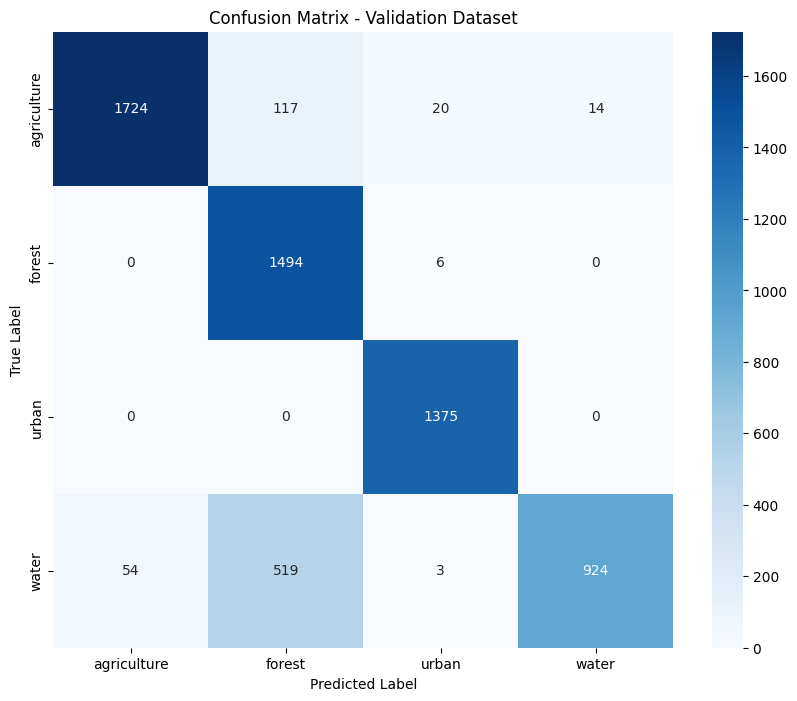

In [49]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix - Validation Dataset')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 9. Output Prediction and Probabilities test data

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


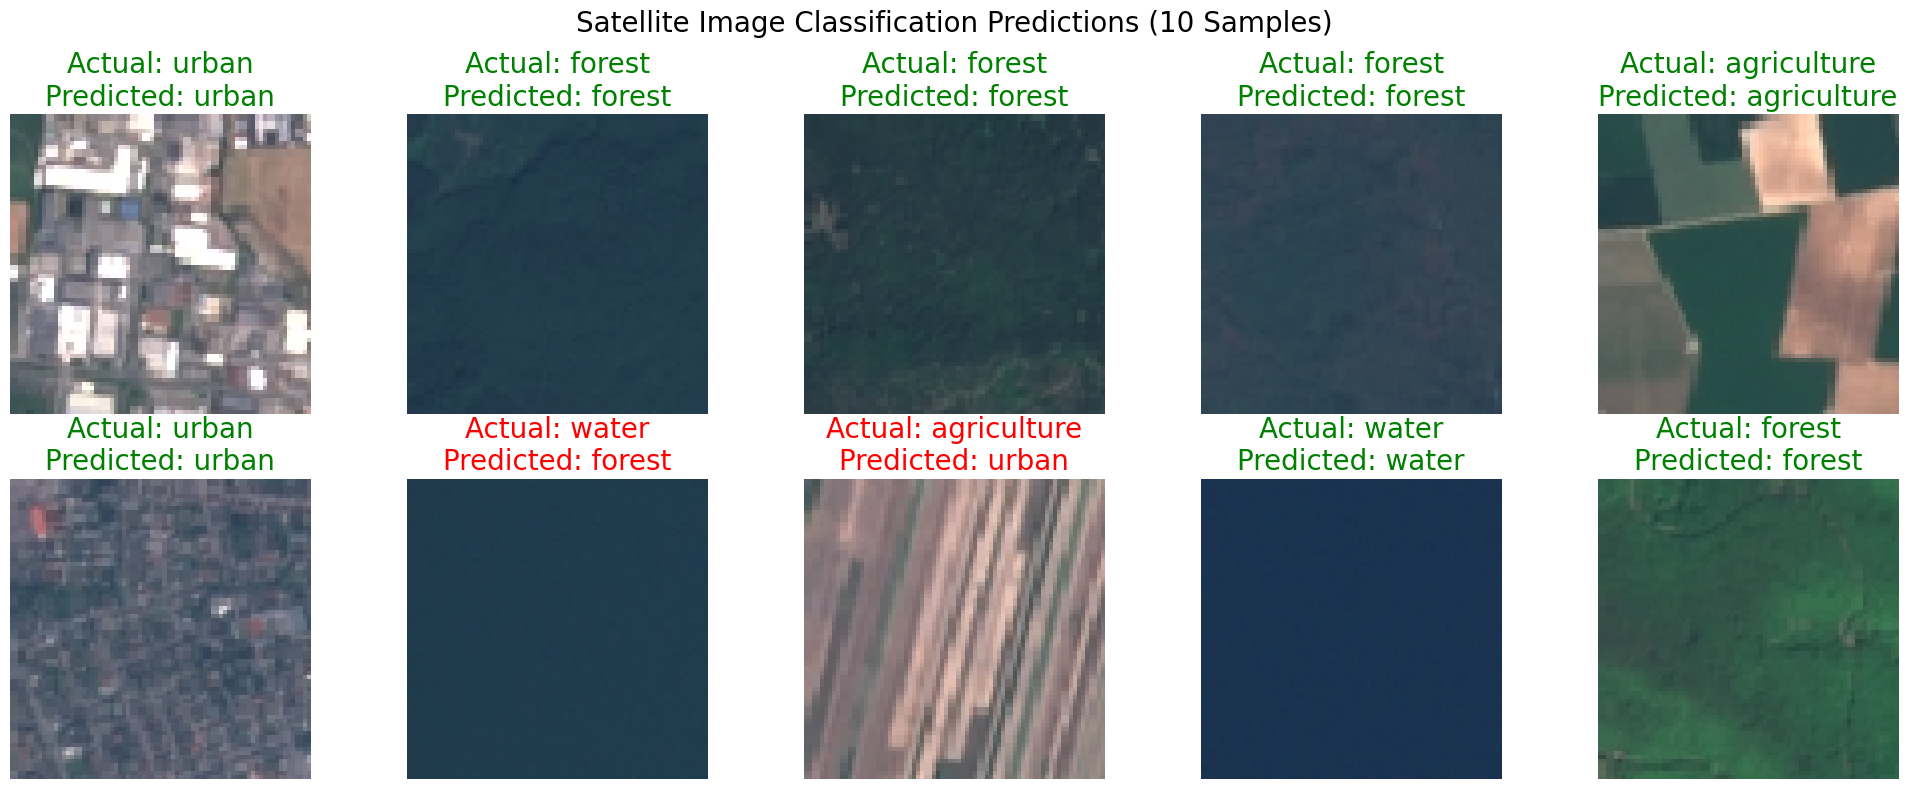

In [50]:
# Get class names from the generator
class_names = list(test_data.class_indices.keys())

num_rows = int(np.ceil(10 / 5))  # Calculate rows dynamically

# Set up the figure size
plt.figure(figsize=(20, 8))

# Extract 10 images and their labels from the test generator
test_images, test_labels = next(test_data)  # Fetch a single batch from test_data
test_images = test_images[:10]
test_labels = test_labels[:10]

# Loop through the samples for display
for i in range(10): 
    # Preprocess the image for prediction
    img = test_images[i]  # Already preprocessed by ImageDataGenerator
    true_class = np.argmax(test_labels[i])  # Get the true label
    predicted_class = np.argmax(model.predict(np.expand_dims(img, axis=0)), axis=-1)  # Predict class
    # Determine if the prediction is correct
    is_correct = true_class == predicted_class[0]
    # Set the color based on whether the prediction is correct
    title_color = 'green' if is_correct else 'red'
    # Display the image
    plt.subplot(num_rows, 5, i + 1)
    plt.imshow(img)  # Image is already scaled between 0 and 1
    plt.title(f"Actual: {class_names[true_class]}\nPredicted: {class_names[predicted_class[0]]}", fontsize = 20, color=title_color)
    plt.axis('off')

# Add a global title
plt.suptitle('Satellite Image Classification Predictions (10 Samples)', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust spacing for the title
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted Class: forest
Confidence: 99.69%


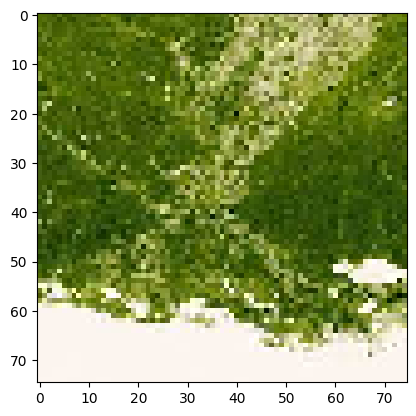

In [77]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the image
img_path = "./manualTest/test1.jpg"  # Replace with your image path
img = image.load_img(img_path, target_size=(75, 75))  # Resize to target size

# Convert to numpy array
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Apply the same preprocessing as training
datagen = image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.3,
    horizontal_flip = True,
    zoom_range = 0.2,
    brightness_range=[0.8, 1.2],  # Adjust brightness
    fill_mode='nearest'
)

# Process image using datagen
img_preprocessed = next(datagen.flow(img_array, batch_size=1))

# Make prediction
predictions = model.predict(img_preprocessed)
predicted_class_index = np.argmax(predictions, axis=1)[0]

# Get class labels
class_labels = list(train_data.class_indices.keys())
predicted_class_name = class_labels[predicted_class_index]

print(f"Predicted Class: {predicted_class_name}")
print(f"Confidence: {np.max(predictions) * 100:.2f}%")

plt.imshow(img)

In [1]:
from keras.models import load_model
from keras.utils import plot_model

# Load your trained model
model = load_model("finalDataModel.keras")

# Generate and save the block diagram
plot_model(model, to_file="model_block_diagram.png", show_shapes=True, show_layer_names=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
